In [1]:
import requests 
import json
from pprint import pprint
import os
import pandas as pd
import csv
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as sts
import gmaps
from scipy.stats import sem
from scipy.stats import linregress
from config import Q1api_key
from config import Q1_GKey

In [2]:
# # Import Merged GDP and Weather data
merge_path = os.path.join("Resources", "Merge_data_2005-2015.csv")
merge_df = pd.read_csv(merge_path)

merge_df.head()

,Unnamed: 0,ISO3,Country,Year,Temp_Farenheit,Rainfall_mm,GDP,GDP_md,GDP_bd
0,0,AFG,Afghanistan,2005,56.087945,29.609967,6.209138e+09,6209.137625,6.209138
1,1,AFG,Afghanistan,2006,57.501470,27.120458,6.971286e+09,6971.285595,6.971286
2,2,AFG,Afghanistan,2007,56.320054,25.329681,9.747880e+09,9747.879532,9.747880
3,3,AFG,Afghanistan,2008,56.755070,21.505365,1.010923e+10,10109.225814,10.109226
4,4,AFG,Afghanistan,2009,56.807912,31.106477,1.243909e+10,12439.087077,12.439087


In [3]:
# # Understand the data
max_Temp = merge_df['Temp_Farenheit'].max()
min_Temp = merge_df['Temp_Farenheit'].min()
print(f"Maximum temperature in data is {max_Temp}")
print(f"Minimum temperature in data is {min_Temp}")

max_GDP = merge_df['GDP_bd'].max()
min_GDP = merge_df['GDP_bd'].min()
print(f"Maximum GDP in data is {max_GDP}")
print(f"Minimum GDP in data is {min_GDP}")

Maximum temperature in data is 85.173935
Minimum temperature in data is 0.8050399999999988
Maximum GDP in data is 18219.3
Minimum GDP in data is 0.02183909889


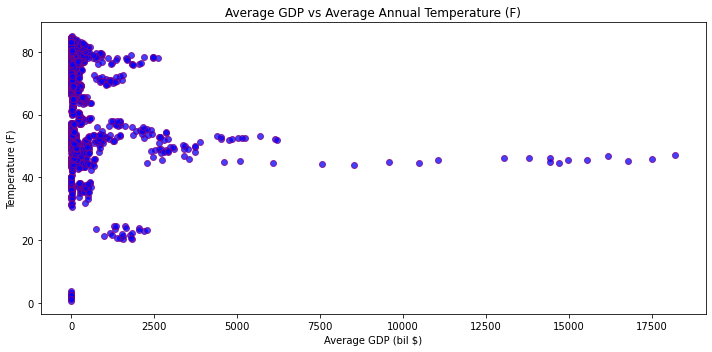

In [4]:
# # Plot all the data
# Plot the Rainfall versus GDP data to look for trend/features to investigate
ListofISO34Plot = merge_df['ISO3']
# # Make Scatter plot of Rainfall vs GDP  
plt.figure(figsize=(10,5))
plt.scatter(merge_df["GDP_bd"], merge_df["Temp_Farenheit"], marker='o', facecolor='b', edgecolors='purple', alpha = 0.75)
plt.title(f"Average GDP vs Average Annual Temperature (F)")
plt.xlabel("Average GDP (bil $)")
plt.ylabel("Temperature (F)")
plt.tight_layout()
plt.savefig("output_data/Q2/Fig1x_AvTemp_vs_GDP_AllCountries.png")
plt.show()

In [5]:
# Crop data to area of interest
zone1_df = merge_df.loc[(merge_df['Temp_Farenheit']>=40) & (merge_df['Temp_Farenheit']<=60)]
zone1_df

zone2_df = merge_df.loc[(merge_df['Temp_Farenheit']>=70) & (merge_df['Temp_Farenheit']<=86)]
zone2_df

zone3_df = merge_df.loc[(merge_df['Temp_Farenheit']>=18) & (merge_df['Temp_Farenheit']<=28)]
zone3_df

# Create a merged (zone1, 2 & 3) dataframe
ZONE_df = merge_df.loc[(merge_df['Temp_Farenheit']>=18) & (merge_df['Temp_Farenheit']<=28) | (merge_df['Temp_Farenheit']>=40) & (merge_df['Temp_Farenheit']<=60) | (merge_df['Temp_Farenheit']>=70) & (merge_df['Temp_Farenheit']<=86)]
ZONE_df = ZONE_df.dropna(how='any')


# # Understand the data
ZoneCountries = ZONE_df['ISO3'].nunique()
print(f"No. of countries after filter {ZoneCountries}")

ZONE_df

No. of countries after filter 170


,Unnamed: 0,ISO3,Country,Year,Temp_Farenheit,Rainfall_mm,GDP,GDP_md,GDP_bd
0,0,AFG,Afghanistan,2005,56.087945,29.609967,6.209138e+09,6209.137625,6.209138
1,1,AFG,Afghanistan,2006,57.501470,27.120458,6.971286e+09,6971.285595,6.971286
2,2,AFG,Afghanistan,2007,56.320054,25.329681,9.747880e+09,9747.879532,9.747880
3,3,AFG,Afghanistan,2008,56.755070,21.505365,1.010923e+10,10109.225814,10.109226
4,4,AFG,Afghanistan,2009,56.807912,31.106477,1.243909e+10,12439.087077,12.439087
...,...,...,...,...,...,...,...,...,...
2063,2140,ZWE,Zimbabwe,2011,71.085215,63.126104,1.410192e+10,14101.920300,14.101920
2064,2141,ZWE,Zimbabwe,2012,71.438135,45.312368,1.711485e+10,17114.849900,17.114850
2065,2142,ZWE,Zimbabwe,2013,70.923830,51.234424,1.909102e+10,19091.020000,19.091020
2066,2143,ZWE,Zimbabwe,2014,71.078870,50.608135,1.949552e+10,19495.519600,19.495520


In [6]:
# # Looking for Regressions
# Looking at the trend line for temperature over time (10yrs) for each country and GDP over time for 
# the same country storing these values to compare them.

# FOR COMBINED ZONES OF INTEREST
ListofISO3_Merged = ZONE_df['ISO3']
ZONERegressList = []
ZONERegressDictGDP = {}
ZONERegressDictTemp = {}
R_ValuesGDP = {}
R_ValuesTemp = {}

# Run for loop to get regression values for GDP for each country
for ISO in ListofISO3_Merged:
    ZONECorrelation_df = ZONE_df.loc[ZONE_df['ISO3']== ISO]
    GDP = ZONECorrelation_df['GDP']
    Temps = ZONECorrelation_df['Temp_Farenheit']
    Yrs = ZONECorrelation_df['Year']    

    #  LINEAR REGRESSION MODEL 
    # Run the regression and store each of the returned values
    slope, intercept, rvalue, pvalue, stderr = linregress(Yrs, GDP)
    Zone_regression = [slope, intercept, rvalue, pvalue, stderr]
    Zone_Rvalue = Zone_regression[2]
    ZONERegressDictGDP[ISO] = Zone_Rvalue
R_ValuesGDP = ZONERegressDictGDP

# Run for loop to get regression values for annual average Temperature for each country
for ISO in ListofISO3_Merged:
    ZONECorrelation_df = ZONE_df.loc[ZONE_df['ISO3']== ISO]
    GDP = ZONECorrelation_df['GDP']
    Temps = ZONECorrelation_df['Temp_Farenheit']
    Yrs = ZONECorrelation_df['Year']    

    #  LINEAR REGRESSION MODEL 
    # Run the regression and store each of the returned values
    slope, intercept, rvalue, pvalue, stderr = linregress(Yrs, Temps)
    Zone_regression = [slope, intercept, rvalue, pvalue, stderr]
    Zone_Rvalue = Zone_regression[2]
    ZONERegressDictTemp[ISO] = Zone_Rvalue
R_ValuesTemp = ZONERegressDictTemp


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_stats_mstats_common.py:140: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_stats_mstats_common.py:142: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


In [7]:
# # Comparing GDP and Temperature regressions
# Looking at the difference between the r-value for the GDP trend line and the annual temperature of a given 
# country would help ascertain any relationship.
# For example, a high, positive r-value for the GDP trend line and a smiliar high, positive r-value for the 
# annual temperature trend line indicates the possibility of a correlation.

# # # Understand the data
# maxTempRegression = Regress_df['TEMP_REGRESS'].max()
# minTempRegression = Regress_df['TEMP_REGRESS'].min()
# print(f"Maximum temperature in data is {maxTempRegression}")
# print(f"Minimum temperature in data is {minTempRegression}")

# maxGDPRegression = Regress_df['GDP_REGRESS'].max()
# minGDPRegression = Regress_df['GDP_REGRESS'].min()
# print(f"Maximum temperature in data is {maxGDPRegression}")
# print(f"Minimum temperature in data is {minGDPRegression}")


# Create a df to look at the GDP and Temperature regressions
RegressList ={"TEMP_REGRESS": R_ValuesTemp,"GDP_REGRESS": R_ValuesGDP}
Regress_df = pd.DataFrame(RegressList)
Regress_df = Regress_df.reset_index()
Regress_df = Regress_df.rename(columns={'index': 'ISO3'})
Regress_df['Regression_diff'] = Regress_df['TEMP_REGRESS'] - Regress_df['GDP_REGRESS']
Regress_df = Regress_df.sort_values(by='Regression_diff', ascending=False)
Regress_df.head(50)

,ISO3,TEMP_REGRESS,GDP_REGRESS,Regression_diff
92,LIE,1.000000,-1.000000,2.000000
64,GRC,0.529302,-0.571138,1.100440
3,AND,0.410259,-0.535697,0.945955
78,ITA,0.624100,0.001217,0.622883
116,MNP,-0.017122,-0.598097,0.580975
42,HRV,0.635116,0.065603,0.569513
141,ESP,0.420812,-0.067012,0.487825
124,PRT,0.528980,0.089547,0.439433
91,LBY,0.127641,-0.308688,0.436329
72,HUN,0.605606,0.223934,0.381672


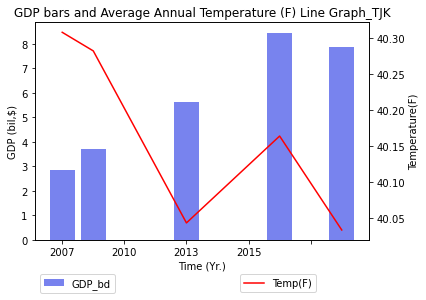

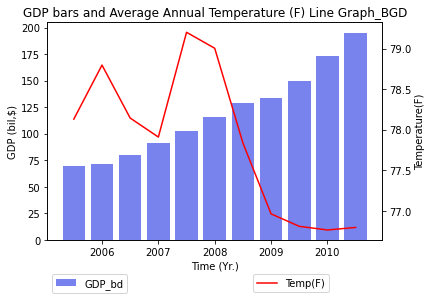

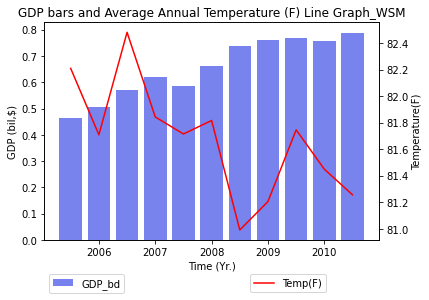

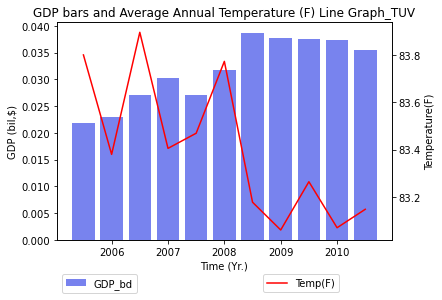

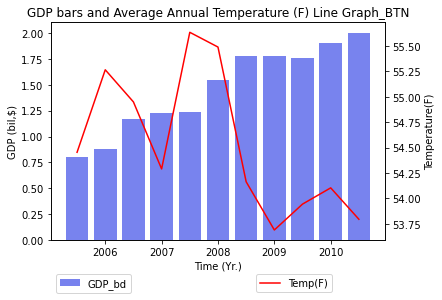

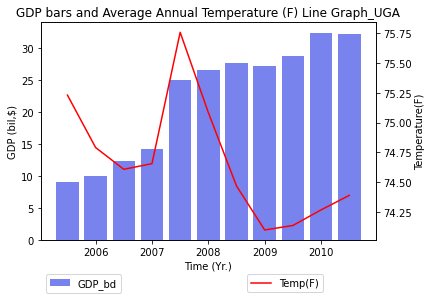

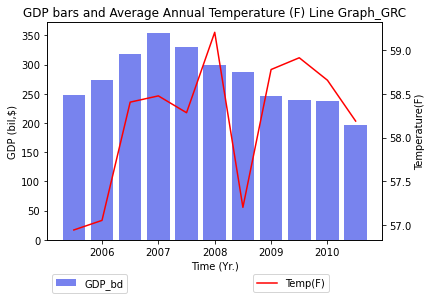

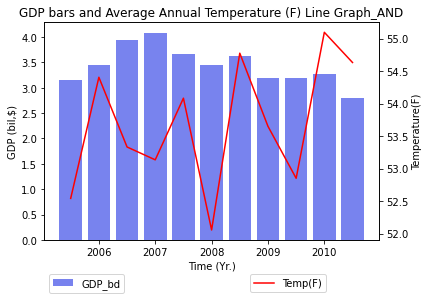

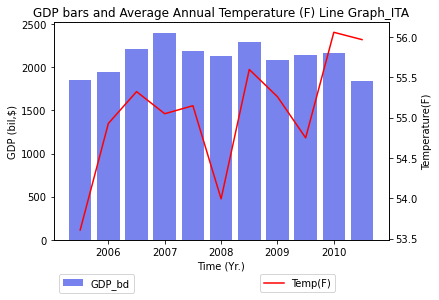

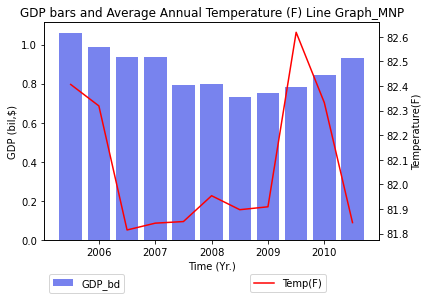

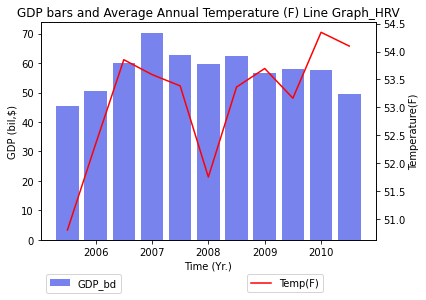

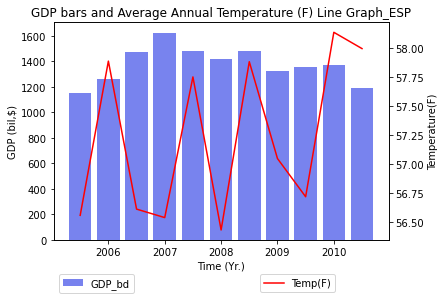

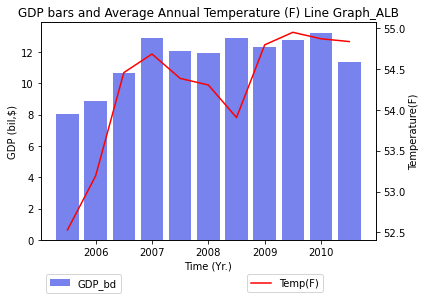

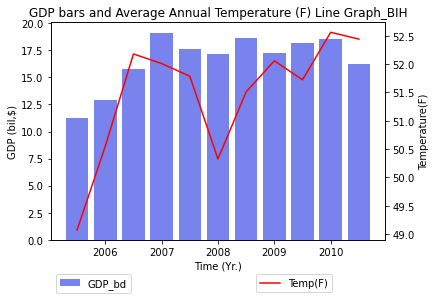

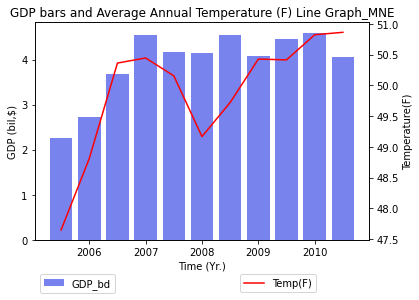

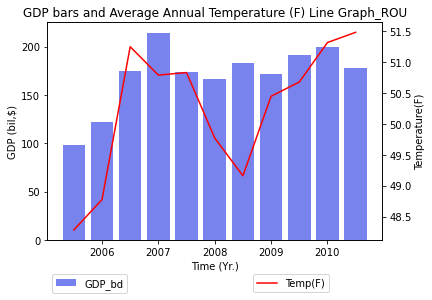

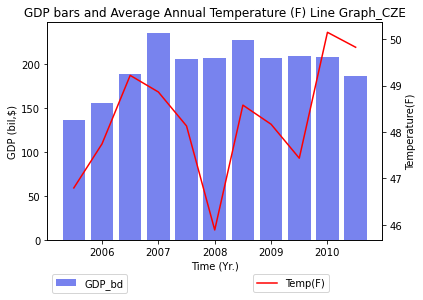

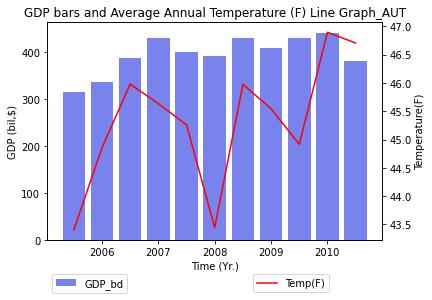

In [8]:
# # Dual axis bar/line chart
# A bar chart/ line graph to compare GDP and annual temperature trends over time.
# Make a ISO List based on findings from regress data frame
RegressList = ['TJK', 'BGD', 'WSM', 'TUV', 'BTN', 'UGA', 'GRC', 'AND', 'ITA', 'MNP', 'HRV', 'ESP', 'ALB', 'BIH', 'MNE', 'ROU', 'CZE', 'AUT']
for ISO in RegressList:
    BarGraph_df = ZONE_df.loc[ZONE_df['ISO3']== ISO]
    yearList = BarGraph_df['Year'].unique()
    yearNo = np.array(range(len(yearList)))
    GDPNos = BarGraph_df['GDP_bd']
    TempNos = BarGraph_df['Temp_Farenheit']
    fig, ax = plt.subplots()
    ax2 = ax.twinx()
    ax.bar(yearList, GDPNos, color=(63/255,79/255,232/255,0.7), label='GDP_bd')
    ax2.plot(yearList, TempNos, color='red', label='Temp(F)')
    ax.set_xticklabels(yearList)
    ax.legend(loc='center left', bbox_to_anchor=(0, -0.2))
    ax2.legend(loc='center left', bbox_to_anchor=(0.6, -0.2))
    ax.set_title(f"GDP bars and Average Annual Temperature (F) Line Graph_{ISO}")
    ax.set_ylabel('GDP (bil,$)')
    ax2.set_ylabel('Temperature(F)')
    ax.set_xlabel('Time (Yr.)')
    plt.savefig(f"output_data/Q1/Fig2_GDP_BarChart_TempLineChart_{ISO}_2005-2015.png")


In [9]:
# Lat long of capital cities of correlated countries
# CorrCountriesList = []
BGD = (23.763889, 90.388889)
TUV = (-8.516667, 179.2)
AND = (42.5, 1.516667)
MNP = (15.19, 145.74)
ALB = (41.316667, 19.816667)
ROU = (44.416667, 26.1)
DOM = (19, -70.666667)
GRC = (37.966667, 23.716667)
CAF = (4.366667, 18.583333)

CorrCountriesList = [ALB, CAF]

In [10]:
# CREATE A GEOXXXX MAP
# STEP 1 ---------------------------------------------------------
# SET UP LAT LONG PAIRS
Coords = CorrCountriesList
Coords

fig = gmaps.figure()

# Create a marker layer using our coordinates
markers = gmaps.marker_layer(Coords)

# Add the layer to the map
fig.add_layer(markers)

# display the figure with the newly added layer
fig

Figure(layout=FigureLayout(height='420px'))